# Assess income level predictions on adult census data

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import raimitigations.dataprocessing as dp

import pandas as pd
import pickle
from lightgbm import LGBMClassifier
import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager
from raimitigations.dataprocessing import EncoderOHE
import warnings
warnings.filterwarnings("ignore")

In [15]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True, figname = 'fig.png'):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})
    
    y_label = "Occurrences"
    if normalize:
        y_label = "Fraction"

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Cohorts", fontsize=50)
    ax.set_ylabel(y_label, fontsize=50)
    ax.tick_params(labelsize=50)
    plt.legend(fontsize=50)
    plt.savefig(figname)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

target_feature = 'income'
categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'gender', 'native-country']

train_data = pd.read_csv('adult-train.csv', skipinitialspace=True, header=0)
test_data = pd.read_csv('adult-test-sample.csv', skipinitialspace=True, header=0)

X_train_original, y_train = split_label(train_data, target_feature)
X_test_original, y_test = split_label(test_data, target_feature)

estimator = LGBMClassifier(random_state=0, n_estimators=5)

# Define the cohorts
c1 = [ [ ['relationship', '==', 'Wife'], 'or', ['relationship', '==', 'Husband']]]
c2 = None

#24720 is the size of the majority class
rebalance = dp.Rebalance(X=X_train_original, y=y_train, verbose=False, strategy_over={0:24720, 1:24720})
new_X, new_y = rebalance.fit_resample()

pipe = Pipeline([
    ("imputer", dp.BasicImputer(verbose=False)),
    ("encoder", dp.EncoderOHE(unknown_err=True)),
    ("model", estimator)
])

pipe.fit(new_X, new_y)


No columns specified for encoding. These columns have been automatically identfied as the following:
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


Pipeline(steps=[('imputer',
                 <raimitigations.dataprocessing.imputer.basic_imputer.BasicImputer object at 0x00000279CBDE44C0>),
                ('encoder',
                 <raimitigations.dataprocessing.encoder.ohe.EncoderOHE object at 0x00000279CBF5DFA0>),
                ('model', LGBMClassifier(n_estimators=5, random_state=0))])

In [17]:
pickle.dump(pipe, open("../rebalance_all_data", 'wb'))

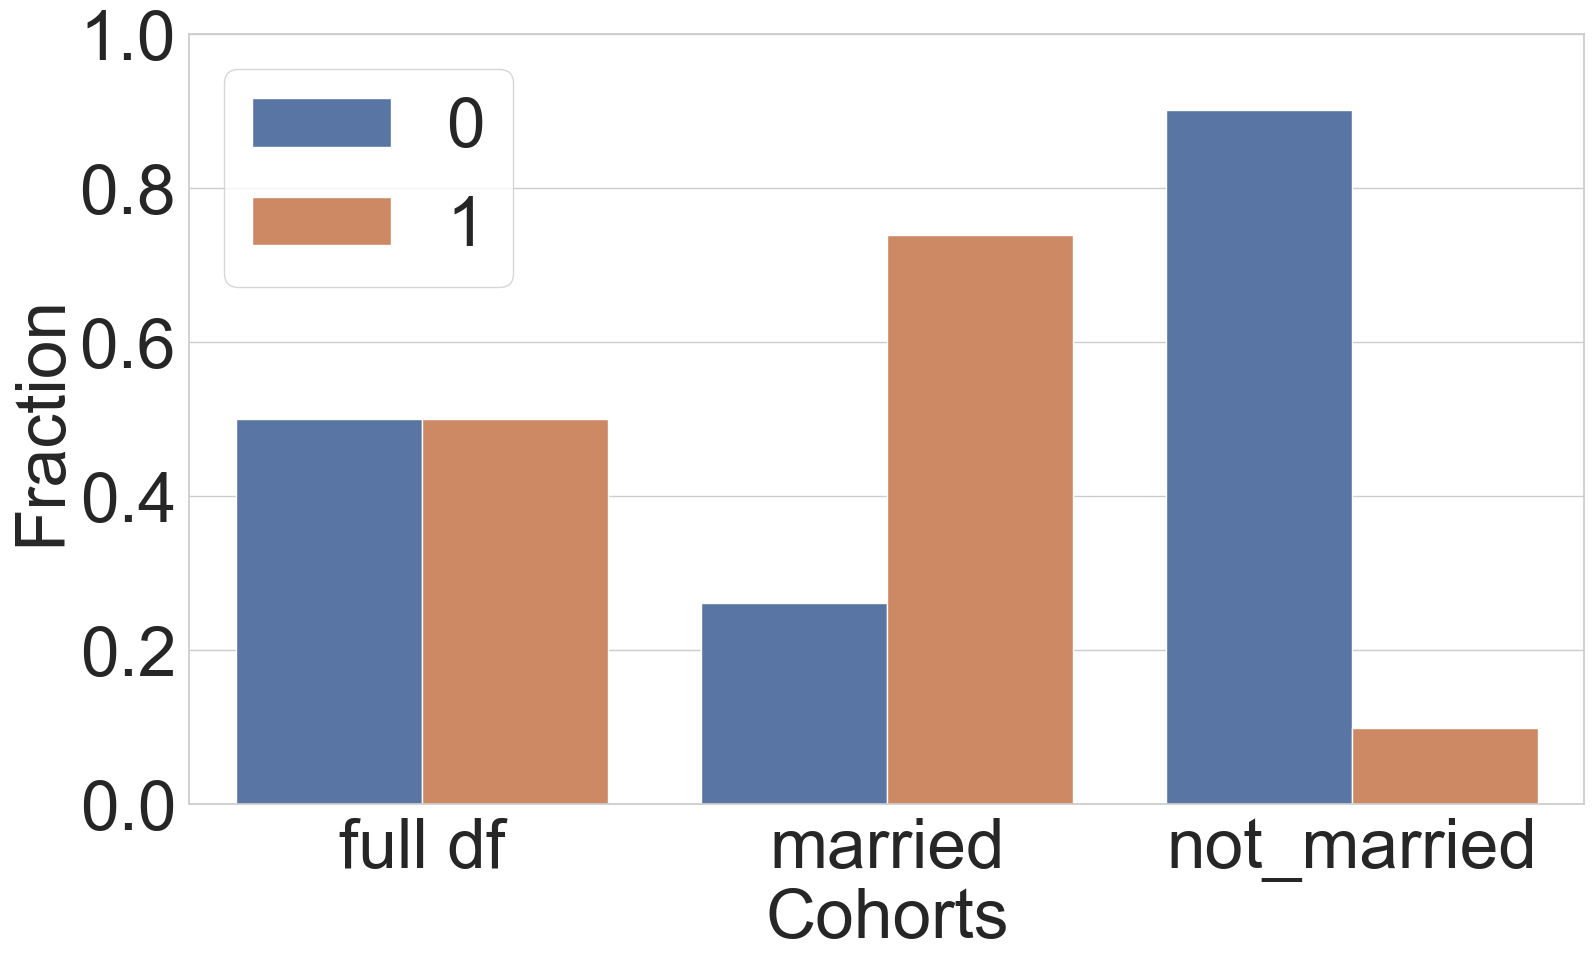

In [18]:
#only for visualization purposes
rebalance_cohort = CohortManager(
    transform_pipe=[],
    cohort_def={"married":c1, "not_married":c2}
    )
rebalance_cohort.fit(new_X, new_y)

subsets = rebalance_cohort.get_subsets(new_X, new_y, apply_transform=False)
plot_value_counts_cohort(new_y, subsets, normalize=True, figname='images/after_mitigation_rebalance_all_data.png')